In [59]:
import torch
import os
import random
import pathlib
import torchvision

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch import nn
from pathlib import Path
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from typing import Tuple, Dict, List

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [61]:
data_path = Path("./data/")
image_path = data_path / "car_bike"

In [62]:
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 2 images in data\car_bike
There are 2 directories and 0 images in data\car_bike\test
There are 0 directories and 2 images in data\car_bike\test\bike
There are 0 directories and 2 images in data\car_bike\test\car
There are 2 directories and 0 images in data\car_bike\train
There are 0 directories and 4 images in data\car_bike\train\bike
There are 0 directories and 4 images in data\car_bike\train\car


In [63]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir , test_dir

(WindowsPath('data/car_bike/train'), WindowsPath('data/car_bike/test'))

Random image path: data\car_bike\train\bike\bike1.jpeg
Image class: bike
Image height: 159
Image width: 318


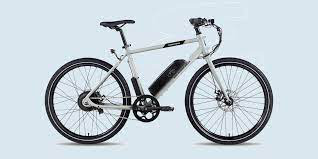

In [64]:
# Visualize images
import random
from PIL import Image

#set seed
#random.seed(20)

image_path_list = list(image_path.glob("*/*/*.jpeg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [65]:
train_transform = transforms.Compose([
                                transforms.Resize(size=(64,64)),
                                transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                transforms.ToTensor()
])

test_transform = transforms.Compose([
                                transforms.Resize(size=(64,64)),
                                transforms.ToTensor()
])

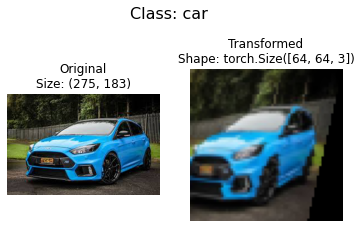

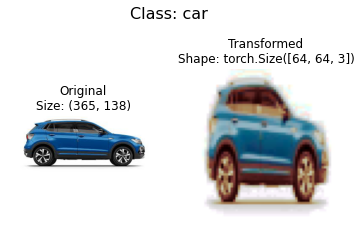

In [66]:
def plot_transformed_images ( image_paths:list, transform, n=3, seed=None):
    """ 
    Selects random images from a path of images and loads/transforms
    them then plots the orginal vs the transformed version
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1,2,0) 
            # permute change the dimension (C,H,W) -> (H,W,C) bcs 
            # plt.imshow need different dimension info
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
    
plot_transformed_images(image_paths=image_path_list,transform=train_transform,n=2)

In [67]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory""" 
    classes = sorted([entry.name for entry in list(os.scandir(directory))])

    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory} ...  please check file structure.")
    
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

find_classes(train_dir)

(['bike', 'car'], {'bike': 0, 'car': 1})

In [68]:
class CustomImageFolder(Dataset):
    def __init__(self, targ_dir: str, transform=None):
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpeg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, index: int) -> Image.Image:
        """Open an image via a path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        """Return the total number of samples"""
        return len(self.paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Return one sample of data, data and label (X, y)"""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img) , class_idx
        else:
            return img, class_idx

In [69]:
train_data = CustomImageFolder(targ_dir=train_dir, transform=train_transform)
test_data = CustomImageFolder(targ_dir=test_dir, transform=test_transform)

In [70]:
class_names = train_data.classes

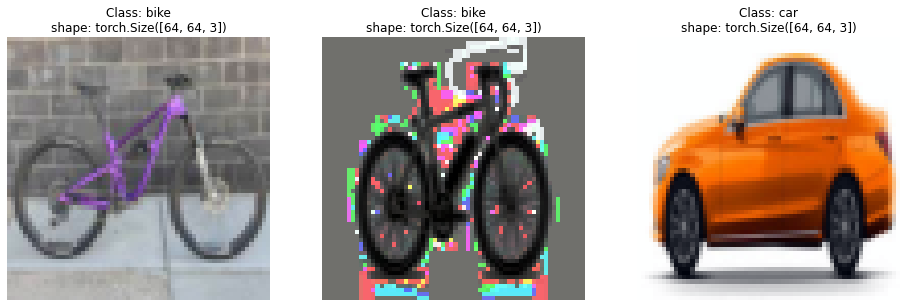

In [71]:
# function to display random images

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    if seed:
        random.seed(seed)

    random_sample_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16,8))

    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0] , dataset[targ_sample][1]

        targ_image_adjust = targ_image.permute(1,2,0)
        
        plt.subplot(1, n , i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

display_random_images(train_data, n=3, classes=class_names, seed=42)

In [72]:
## Create TinyVGG from Scratch
class TinyVGG(nn.Module):
    """TinyVGG copy from CNN Explainer"""
    def __init__(self, 
                input_shape: int, # color_channel
                hidden_units: int, 
                output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, # color_channel
                      out_channels= hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels= hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels= hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels= hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape) # total_class_number
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [73]:
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device=device)

In [74]:
from torchinfo import summary
summary(model, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [75]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    model.train()
    train_loss , train_acc = 0,0

    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device) , y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [76]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    model.eval()
    test_loss, test_acc = 0,0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device) , y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss , test_acc

In [77]:
# create train() combine train_step() test_step()

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
    results = {"train_loss": [],
                "train_acc": [],
                "test_loss": [],
                "test_acc": []}
    for epoch in tqdm(range(epochs)):
        train_loss , train_acc = train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
        test_loss , test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [78]:
# Custom loaded images to DataLoader

from torch.utils.data import DataLoader

BATCH_SIZE = 2
train_dataloader = DataLoader(dataset=train_data,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x19ed04cd280>,
 <torch.utils.data.dataloader.DataLoader at 0x19ed04cd9a0>)

In [79]:
# Train and evaluate
# random seed just for education only
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total train time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6939 | train_acc: 0.5000 | test_loss: 0.6932 | test_acc: 0.5000
Epoch: 2 | train_loss: 0.7034 | train_acc: 0.5000 | test_loss: 0.6941 | test_acc: 0.5000
Epoch: 3 | train_loss: 0.6926 | train_acc: 0.5000 | test_loss: 0.6906 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.6888 | train_acc: 0.5000 | test_loss: 0.6872 | test_acc: 0.5000
Epoch: 5 | train_loss: 0.6792 | train_acc: 0.8750 | test_loss: 0.6808 | test_acc: 1.0000
Total train time: 0.356 seconds


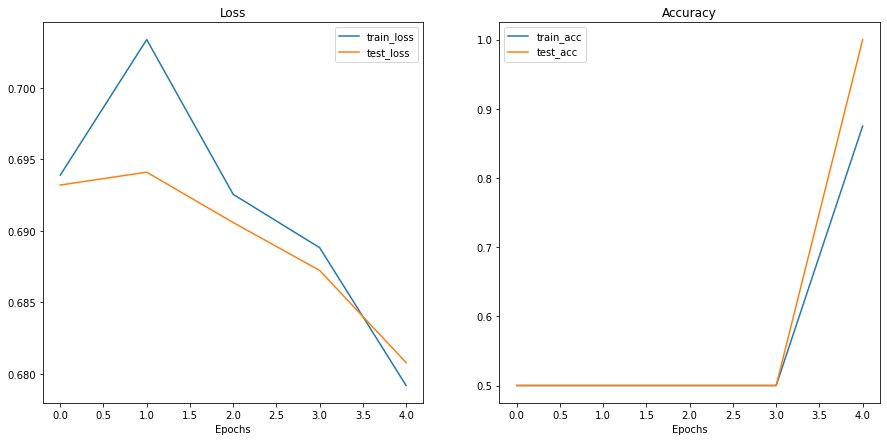

In [80]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """ Plot training curves"""
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="train_acc")
    plt.plot(epochs, test_accuracy, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(model_results)

In [81]:
# transform pipeline to resize custom image
prediction_image_transform = transforms.Compose([
                                    transforms.Resize(size=(64,64))
])

custom_image_path = image_path / "bike11.jpeg"

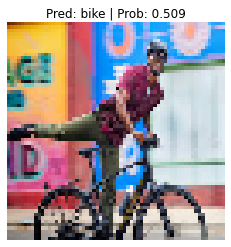

In [82]:
def pred_plot_image(model: torch.nn.Module,
                    image_path: str,
                    class_names: List[str] = None,
                    transform = None,
                    device = device):
    """Make a prediction on an image with trained model and plots the image and prediction"""
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = target_image / 255.
    if transform:
        target_image = transform(target_image)
    model.to(device)
    
    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(0)
        target_image_pred = model(target_image.to(device))
    
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(target_image.squeeze().permute(1,2,0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_labels.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

pred_plot_image(model=model,
                image_path=custom_image_path,
                class_names=class_names,
                transform=prediction_image_transform,
                device=device)